In [1]:
pip install -U pymorphy2-dicts-ru

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 15.4 MB/s eta 0:00:00


In [2]:
pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 582.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=680f7b8cdd73f43e379d36e7916ebc5ebabdb71a184cfc1a0de6641cf0309820
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [3]:
pip install natasha

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26095 sha256=77367f8f28005503cabef38cb587602bed0269485e7a531cc4e346bedc8f4ad5
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

from nltk import stem
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from string import punctuation
import pymorphy2

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from natasha import (
    Segmenter,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    MorphVocab,
    PER,
    NamesExtractor,
    Doc
)

from yargy import Parser, rule
from yargy.predicates import gram, dictionary

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
df = pd.read_excel('/itsm_incident.xlsx')
df

,Номер,Заявитель,Тема,Описание,Краткое описание,Статус,Приоритет,Кому назначен,SLA нарушено,Инфраструктурный инцидент,Кем создано,Когда создано,Кем изменено,Когда изменено
0,INC0005659,Ivan Zhigalov,Утром опять завис и рестартнул контейнер аттач...,NaN,NaN,Закрыт,Критичный,Yuriy Ryabovichev,False,False,Ivan Zhigalov,2022-12-30 10:59:15,Aleksandr Zhulanov,2023-01-09 12:06:28
1,INC0005658,Людмила Романенко,Задержка в выборке писем из ящика после простоев,"Добрый день,\n\nНаблюдаем уже не первый раз. П...",NaN,В разработке,Высокий,Yuriy Ryabovichev,False,False,Людмила Романенко,2022-12-30 10:46:29,Yuriy Ryabovichev,2023-01-26 13:58:48
2,INC0005657,Дмитрий Мелькин,Проблема с отображением Related Tickets,Добрый день!\nПосле обновления платформы некот...,NaN,Закрыт,Высокий,Nikolay Mamchenko,False,False,Дмитрий Мелькин,2022-12-29 14:50:23,Дмитрий Мелькин,2023-01-16 13:43:07
3,INC0005656,Pavel Taranov,Некорректное отображение кнопок UI-action на ф...,На портальной форме кнопки не имеют по дефолту...,NaN,Закрыт,Низкий,Vladislav Safonov,False,False,Pavel Taranov,2022-12-29 12:42:14,System User,2023-01-24 14:30:56
4,INC0005655,Людмила Романенко,GRPC Server is unavailable,"Добрый день, на проде в ошибках появилось сооб...",NaN,В разработке,Высокий,Yuriy Ryabovichev,False,False,Maksim Zheleznyakov,2022-12-29 12:11:09,Yuriy Ryabovichev,2023-10-06 11:29:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582,INC0003655,Boris Bulgakov,Восстановление доступа на home.simpleone.ru,\n\nПропала возможность входа на home.simpleo...,NaN,Закрыт,Низкий,Aleksandr Zhulanov,False,False,Aleksandr Zhulanov,2022-01-10 14:03:15,System User,2022-12-15 17:06:15
1583,INC0003654,Ilya Radchenko,Исходящее письмо обработано со статусом Failed,NaN,NaN,Закрыт,Средний,Aleksandr Zhulanov,False,True,Aleksandr Zhulanov,2022-01-10 10:31:37,System User,2022-12-15 17:04:56
1584,INC0003653,Maksim Zheleznyakov,Исходящее письмо обработано со статусом Failed...,\n Notification Type:: PROBLEM\n Service: Ou...,NaN,Закрыт,Высокий,Aleksandr Zhulanov,False,True,Aleksandr Zhulanov,2022-01-10 10:28:29,System User,2022-12-15 17:04:16
1585,INC0003652,Roman Braslavsky,Уязвимость на инстансе,Добрый день!\nЗаказчиком была обнаружена уязви...,NaN,Закрыт,Высокий,Aleksandr Zhulanov,False,False,Roman Braslavsky,2022-01-10 09:55:00,System User,2022-12-15 17:04:27


In [6]:
df = df[['Тема']]
df

,Тема
0,Утром опять завис и рестартнул контейнер аттач...
1,Задержка в выборке писем из ящика после простоев
2,Проблема с отображением Related Tickets
3,Некорректное отображение кнопок UI-action на ф...
4,GRPC Server is unavailable
...,...
1582,Восстановление доступа на home.simpleone.ru
1583,Исходящее письмо обработано со статусом Failed
1584,Исходящее письмо обработано со статусом Failed...
1585,Уязвимость на инстансе


In [7]:
lemma = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words("russian")

In [8]:
def preprocess(doc: str):
    # чтобы аббревиатуры через дефис (например,  SAS-источник) не склеились
    doc = doc.replace('-', ' ')
    stop_free = " ".join([i for i in doc.lower().split() if i not in russian_stopwords])
    punc_free = ''.join(ch for ch in stop_free if ch not in punctuation)
    text = " ".join([lemma.parse(word)[0].normal_form for word in punc_free.split(' ')])
    return text

In [9]:
df['stem'] = df['Тема'].apply(preprocess)

In [10]:
df

,Тема,stem
0,Утром опять завис и рестартнул контейнер аттач...,утром зависнуть рестартнуть контейнер аттач pr...
1,Задержка в выборке писем из ящика после простоев,задержка выборка письмо ящик простой
2,Проблема с отображением Related Tickets,проблема отображение related tickets
3,Некорректное отображение кнопок UI-action на ф...,некорректный отображение кнопка ui action форм...
4,GRPC Server is unavailable,grpc server is unavailable
...,...,...
1582,Восстановление доступа на home.simpleone.ru,восстановление доступ homesimpleoneru
1583,Исходящее письмо обработано со статусом Failed,исходящий письмо обработать статус failed
1584,Исходящее письмо обработано со статусом Failed...,исходящий письмо обработать статус failed запи...
1585,Уязвимость на инстансе,уязвимость инстанс


# Кластеризация

Векторизуем наши наборы запросов.

In [11]:
vectorizer = TfidfVectorizer(smooth_idf=True, max_df=0.6, min_df=0.01, max_features=100000, use_idf=True, ngram_range=(1,3), decode_error='ignore')
tfidf_matrix = vectorizer.fit_transform(df['stem'])

## MiniBatchKMeans

Полученное векторизованное представление кластеризуем. Воспользуемся методом MiniBatchKMeans.

Выберем число кластеров по графику каменистая осыпь (локоть). Построим график зависимости расстояний между кластерами от шага слияния, и посмотрим, когда это расстояние перестанет значительно меняться.

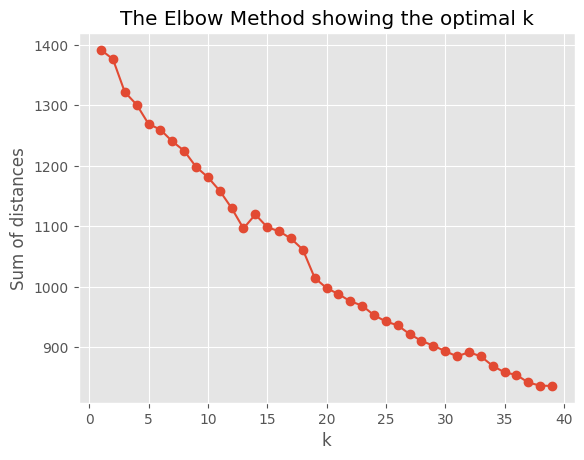

In [ ]:
K = range(1, 40)
models = [MiniBatchKMeans(n_clusters=k, random_state=42, init='random').fit(tfidf_matrix) for k in K]

#качество кластеризации в model.inertia_
dist = [model.inertia_ for model in models]

plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Виден излом на количестве 3 13 19 кластеров.

In [12]:
cluster_number_k_means = 13

In [13]:
k_means_batch = MiniBatchKMeans(n_clusters=cluster_number_k_means, init='random').fit(tfidf_matrix)
labels_k_means_batch = k_means_batch.predict(tfidf_matrix)

In [14]:
df['cluster_k_means'] = labels_k_means_batch
df

,Тема,stem,cluster_k_means
0,Утром опять завис и рестартнул контейнер аттач...,утром зависнуть рестартнуть контейнер аттач pr...,5
1,Задержка в выборке писем из ящика после простоев,задержка выборка письмо ящик простой,5
2,Проблема с отображением Related Tickets,проблема отображение related tickets,1
3,Некорректное отображение кнопок UI-action на ф...,некорректный отображение кнопка ui action форм...,5
4,GRPC Server is unavailable,grpc server is unavailable,5
...,...,...,...
1582,Восстановление доступа на home.simpleone.ru,восстановление доступ homesimpleoneru,9
1583,Исходящее письмо обработано со статусом Failed,исходящий письмо обработать статус failed,5
1584,Исходящее письмо обработано со статусом Failed...,исходящий письмо обработать статус failed запи...,5
1585,Уязвимость на инстансе,уязвимость инстанс,5


Рассмотрим примеры кластеров:

In [24]:
df[df.cluster_k_means == 3]

,Тема,stem,cluster_k_means
21,Некорректное отображение статей при поиске на ...,некорректный отображение стать поиск портал,3
26,Строка поиска на портале,строка поиск портал,3
83,INTSK0000399 не находится в глобальном поиске,intsk0000399 находиться глобальный поиск,3
316,Получаю ошибки при глобальном поиске,получать ошибка глобальный поиск,3
515,Периодически не работает поиск в референсном п...,периодически работать поиск референсон поле вв...,3
563,некорректное (устаревшее) название категории э...,некорректный устаревший название категория эле...,3
604,Поиск по документации SimpleOne,поиск документация simpleone,3
611,медленное обновление таблицы поиска.,медленный обновление таблица поиск,3
683,Нечитаемые KB при использовании поиска,нечитаемый kb использование поиск,3
693,Поиск на портале некорректно работает. Срочно.,поиск портал некорректно работать срочно,3


In [ ]:
df[df.cluster_k_means == 5]

,Тема,stem,cluster_k_means
55,Ошибка Cannot read properties of null (reading...,ошибка cannot read properties of null reading ...,5
157,Ошибка при запуске backend контейнеров,ошибка запуск backend контейнер,5
175,502 ошибка на продукционном окружении,502 ошибка продукционный окружение,5
183,Ошибка выборки через API (SimpleRecord),ошибка выборка api simplerecord,5
191,Ошибка при проверке ansible-playbook для PROD ...,ошибка проверка ansible playbook prod среда,5
213,Ошибка при проверке перед установкой дистрибутива,ошибка проверка установка дистрибутив,5
257,Копятся ошибки Missing Required parameters: query,копиться ошибка missing required parameters query,5
260,502 ошибка на продукционном окружении,502 ошибка продукционный окружение,5
333,Ошибка интеграции с Telegram,ошибка интеграция telegram,5
404,502 ошибка при согласованиях,502 ошибка согласование,5


In [ ]:
df[df.cluster_k_means == 10]

,Тема,stem,cluster_k_means
19,проблема с работой prod,проблема работа prod,10
31,Не корректная работа тега htmlEditor,корректный работа тег htmleditor,10
38,Некорректная работа механизма отката локальных...,некорректный работа механизм откат локальный п...,10
42,проблема с работой prod,проблема работа prod,10
45,Проблема со скоростью работы портала prod,проблема скорость работа портал prod,10
...,...,...,...
1350,Не корректная работа Filter Condition в бизнес...,корректный работа filter condition бизнес правило,10
1403,Сбой в работе архивации на проде Ашан,сбой работа архивация продя ашан,10
1480,Коннектор работы с почтой работает не корректно.,коннектор работа почта работать корректно,10
1526,Некорректная работа условия codition в widget,некорректный работа условие codition widget,10


Попробуем еще один подход к кластеризации.

## Hierarchical clustering

Для иерархической кластеризации нужно задать способ подсчета расстояния между объектами и между кластерами. Выберем расстояние Варда (квадрат евклидова расстояния) для подсчета расстояния между кластерами. Евклидово расстояние - между объектами.

*Примечание. Квадрат евклидова расстояния с точки зрения математики не является расстоянием, так как нарушается неравленство треугольника. Но в кластерном анализе у нас задача - измерить схожесть объектов, квадрат евклидова расстояния здесь применим.*

In [25]:
# Объект, в котором будет хранится информация о последовательном слиянии кластеров
link = linkage(tfidf_matrix.todense(), 'ward', 'euclidean')

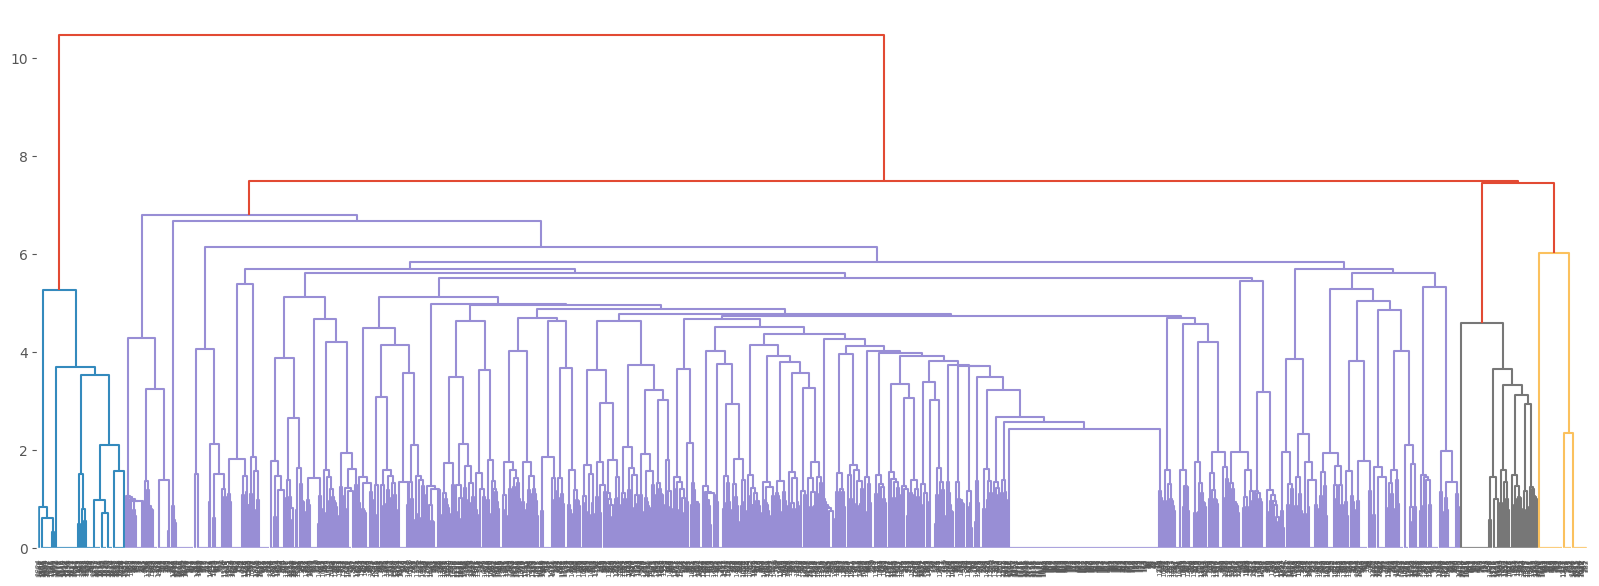

In [26]:
plt.figure(figsize=(20,7))
dn = dendrogram(link)

In [27]:
cluster_hierarchy_number = 13

In [28]:
df['cluster_hierarchy'] = fcluster(link, cluster_hierarchy_number, criterion='maxclust')
df

,Тема,stem,cluster_k_means,cluster_hierarchy
0,Утром опять завис и рестартнул контейнер аттач...,утром зависнуть рестартнуть контейнер аттач pr...,5,6
1,Задержка в выборке писем из ящика после простоев,задержка выборка письмо ящик простой,5,6
2,Проблема с отображением Related Tickets,проблема отображение related tickets,1,7
3,Некорректное отображение кнопок UI-action на ф...,некорректный отображение кнопка ui action форм...,5,7
4,GRPC Server is unavailable,grpc server is unavailable,5,4
...,...,...,...,...
1582,Восстановление доступа на home.simpleone.ru,восстановление доступ homesimpleoneru,9,9
1583,Исходящее письмо обработано со статусом Failed,исходящий письмо обработать статус failed,5,6
1584,Исходящее письмо обработано со статусом Failed...,исходящий письмо обработать статус failed запи...,5,6
1585,Уязвимость на инстансе,уязвимость инстанс,5,13


Посмотрим примеры кластеров:

In [49]:
df[df.cluster_hierarchy == 10]

,Тема,stem,cluster_k_means,cluster_hierarchy
140,Не приостанавливается индикация SLA,приостанавливаться индикация sla,5,10
182,Индикация,индикация,5,10
230,Множественные записи об обновлении SLA Due в и...,множественный запись обновление sla due история,5,10
258,Работа календаря на индикации,работа календарь индикация,2,10
261,Не запускаются индикации на deve и в проде,запускаться индикация deve продя,5,10
277,SLA. Задержка 2 часа перед созданием индикации.,sla задержка 2 час создание индикация,5,10
283,Дублирование индикаций,дублирование индикация,5,10
293,Не создаются индикации на инстансе,создаваться индикация инстанс,5,10
298,Не отрабатывает расчет показателей в индикатор...,отрабатывать расчёт показатель индикатор sla,5,10
365,Не создаются индикации на инстансе,создаваться индикация инстанс,5,10


# Тематика группы запросов: автоматически описать тематику группы запросов

Опишем полученные кластера облаком слов:

In [50]:
def plot_wordcloud(df: pd.DataFrame, max_words=10):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = 80,
                    random_state = 42,
                    width=400,
                    height=400)

    # 13 кластеров, по 3 в строку
    fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(20, 40))

    for i in range(5):
      for j in range(3):
        if 3*i+j+1 > 13:
          break

        text = df.stem[df.cluster_k_means == 3*i+j+1]
        title = f'Word Cloud of Query {3*i+j+1}'

        wordcloud.generate(str(text))

        ax = axs[i, j]
        ax.set_axis_off()
        ax.set_title(title, fontdict={'size': 18, 'color': 'black', 'verticalalignment': 'bottom'})
        ax.imshow(wordcloud);

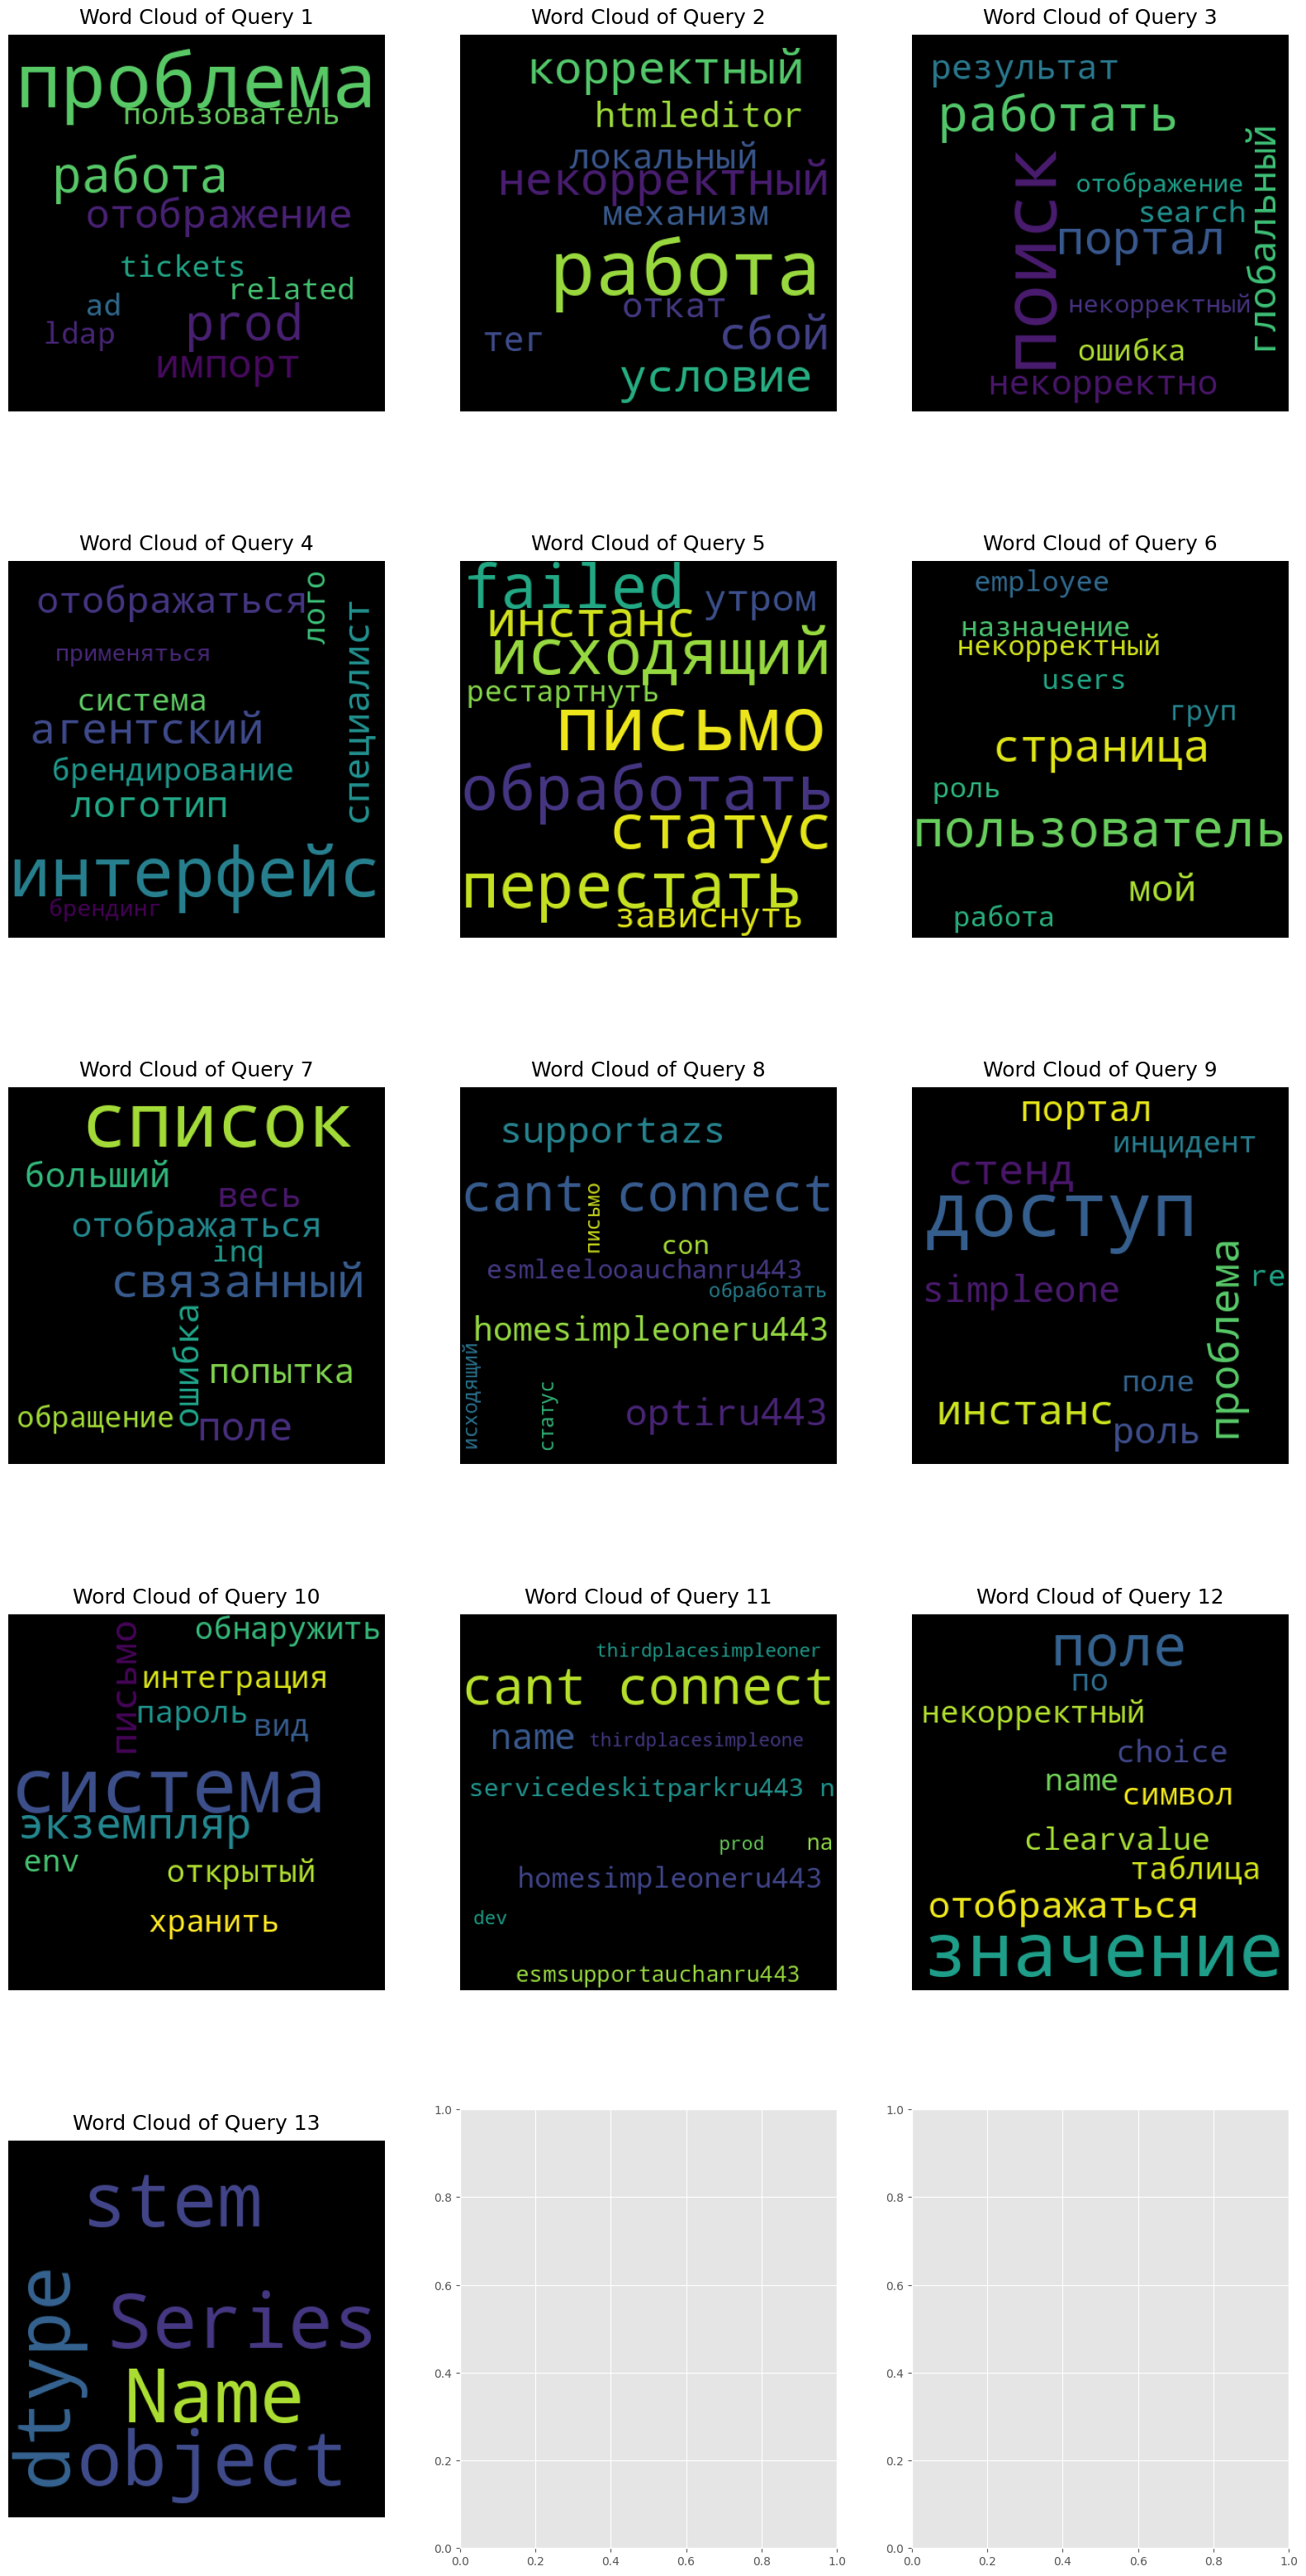

In [51]:
plot_wordcloud(df)

Видим в каждом кластере преобладающие слова. По облаку слов становится ясно, о чем идет речь в рамках рассматриваемого кластера.

# Анализ текста запроса

## Natasha

Используем библиотеку Natasha — это набор качественных инструментов для обработки естественного русского языка (сегментация на токены и предложения, предобученные эмбеддинги, анализ морфологии и синтаксиса, лемматизация).

Напишем функцию для выделения имен (причем для наглядности работы библиотеки сделаем сегментацию и лемматизацию средствами библиотеки Natasha)

In [ ]:
segmenter = Segmenter()
emb = NewsEmbedding()

morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

morph_vocab = MorphVocab()
names_extractor = NamesExtractor(morph_vocab)

In [ ]:
def extract_names(text: str):
  doc = Doc(text)

  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  doc.parse_syntax(syntax_parser)
  doc.tag_ner(ner_tagger)

  for token in doc.tokens:
    token.lemmatize(morph_vocab)

  for span in doc.spans:
    span.normalize(morph_vocab)

  for span in doc.spans:
    if span.type == PER:
      span.extract_fact(names_extractor)

  return {_.normal: _.fact.as_dict for _ in doc.spans if _.type == PER}

## Yargy

Далее найдем аббревиатуры. В случае, когда необходимо создать новое правило для извлечения данных, Yargy-парсер является хорошим решением. Данная библиотека является частью большого проекта Natasha.

In [ ]:
def find_abbreviation(text: str):
  rule_abbrev = rule(dictionary({'кс', 'sas'}))
  parser = Parser(rule_abbrev)

  result = []
  for match in parser.findall(text):
    result.append([x.value for x in match.tokens])

  return result

In [ ]:
df['abbrev'] = df['stem'].apply(find_abbreviation)

Рассмотрим пример строк с аббревиатурой: